## Test the neural network

In this notebook it is shown how to test the model after training. The perforamce of the model is evaluated by calculating the R2 score between the values of the column heights predicted by the model and the true values of the heights. Here the model is tested using a set of weights corresponding to a single epoch, but with test.py the user can test the model with the sets of weights computed in all the training epochs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from net_architecture import CNN
from performance import performance_CH

Using TensorFlow backend.


Load the training data from folder. Here we have provided two folders:

- my_test: 20 samples of simulated HRTEM images with the corresponding labels and predictions. The user can use these test data to visualize the performance of the model without the need of re-training and test the neural network from scratch.

- test: folder containing simulated HRTEM test images that could be generated by the users by running 'make_test_data.py'. In this way the user can generate new test data depending on the needs. Such images must be tested only after re-training the model from scratch running 'training.py' on a corresponding training set. Once the model is trained, the user has to test the model to visualize the results.

In [2]:
test_images_path='data/my_test/images/image_{}.npy'
test_labels_path='data/my_test/labels/label_{}.npy'
test_predictions_path='data/my_test/predictions/prediction_{}.npy'

#test_images_path='data/test/images/image_{}.npy'
#test_labels_path='data/test/labels/label_{}.npy'

Visualizing the simulated HRTEM test images

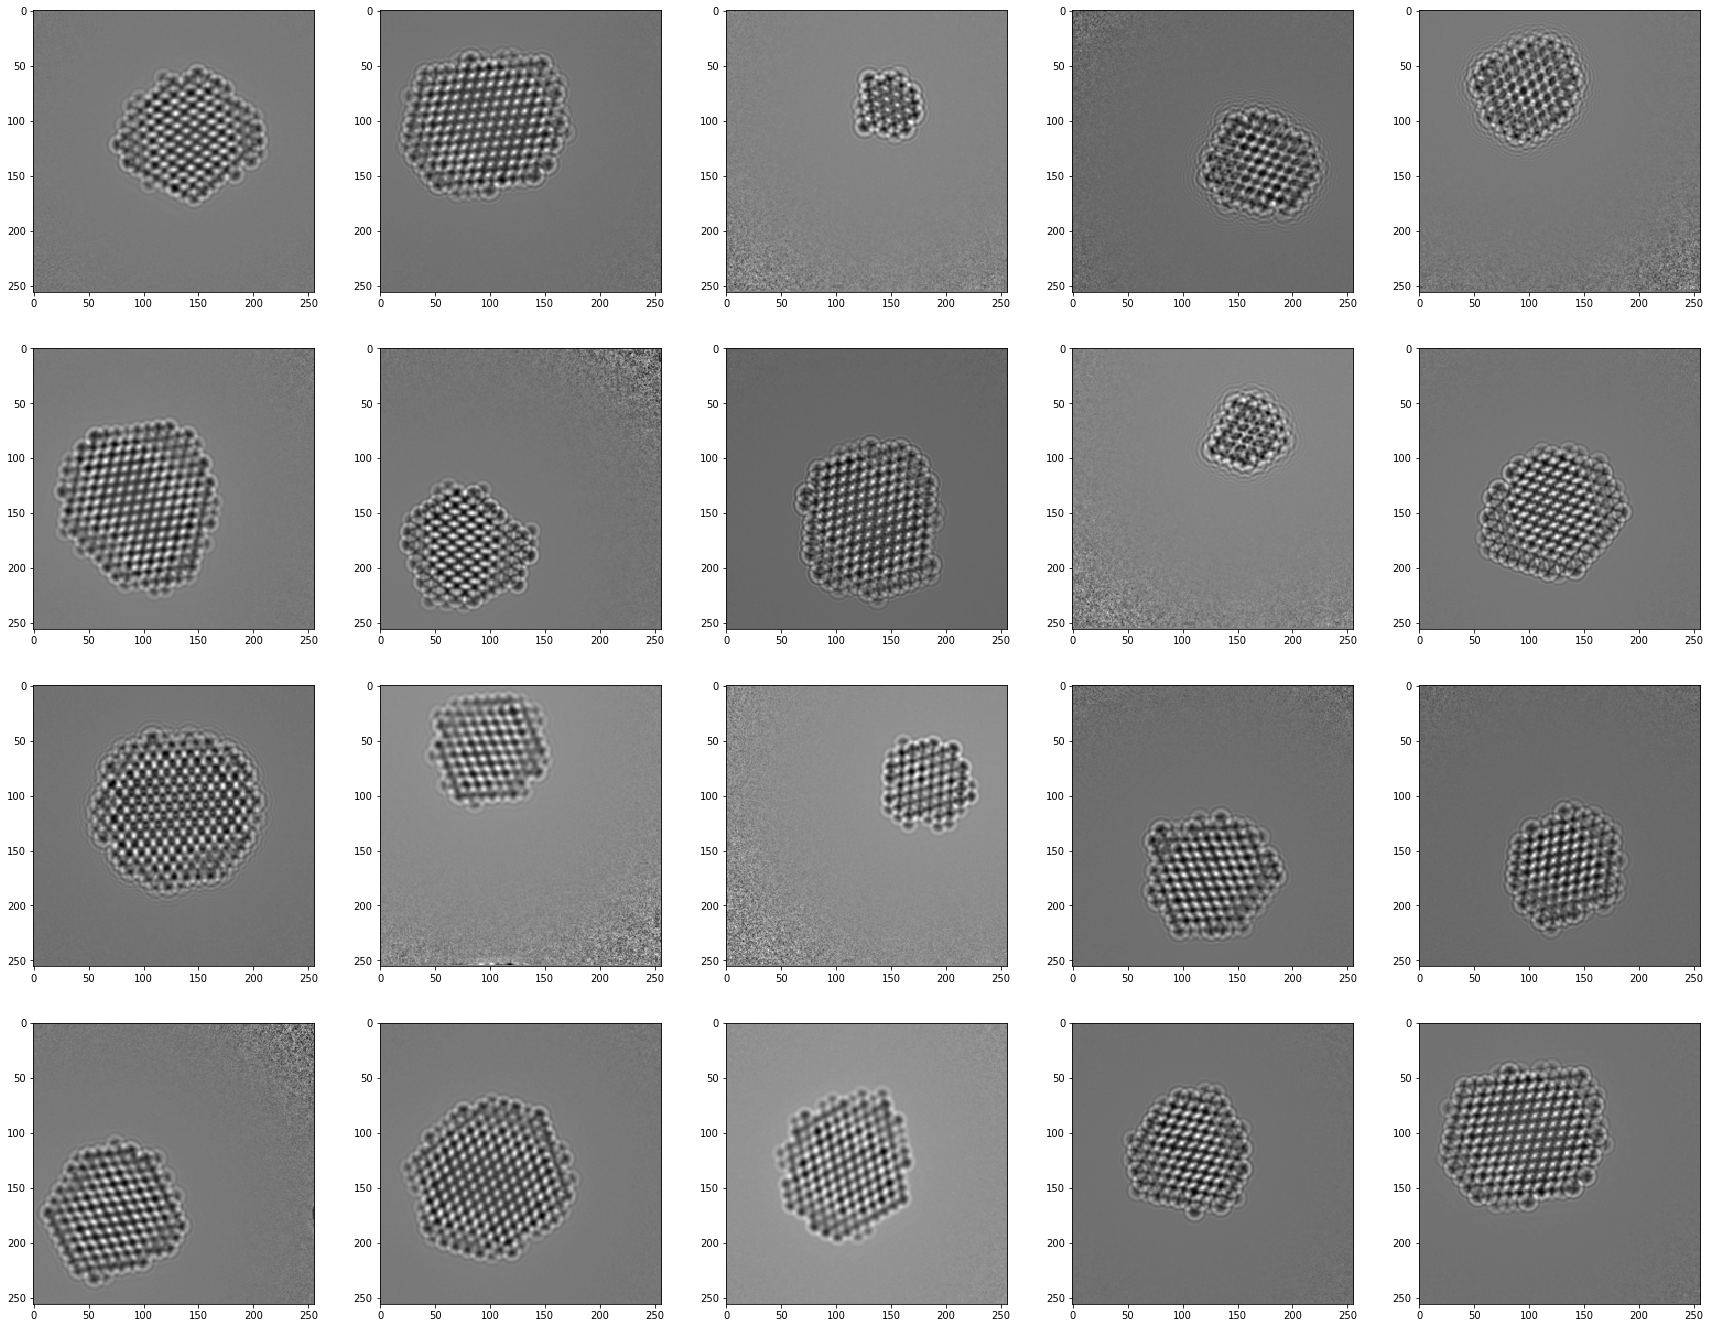

In [3]:
fig=plt.figure(figsize=(30,30))
for i in range(20):
    image=np.load(test_images_path.format(i))
    fig.add_subplot(5,5,i+1)

    plt.imshow(image[0,:,:,0],'gray')

Visualizing the corresponding labels. The colorbar displays the number of atoms in the atomic columns.

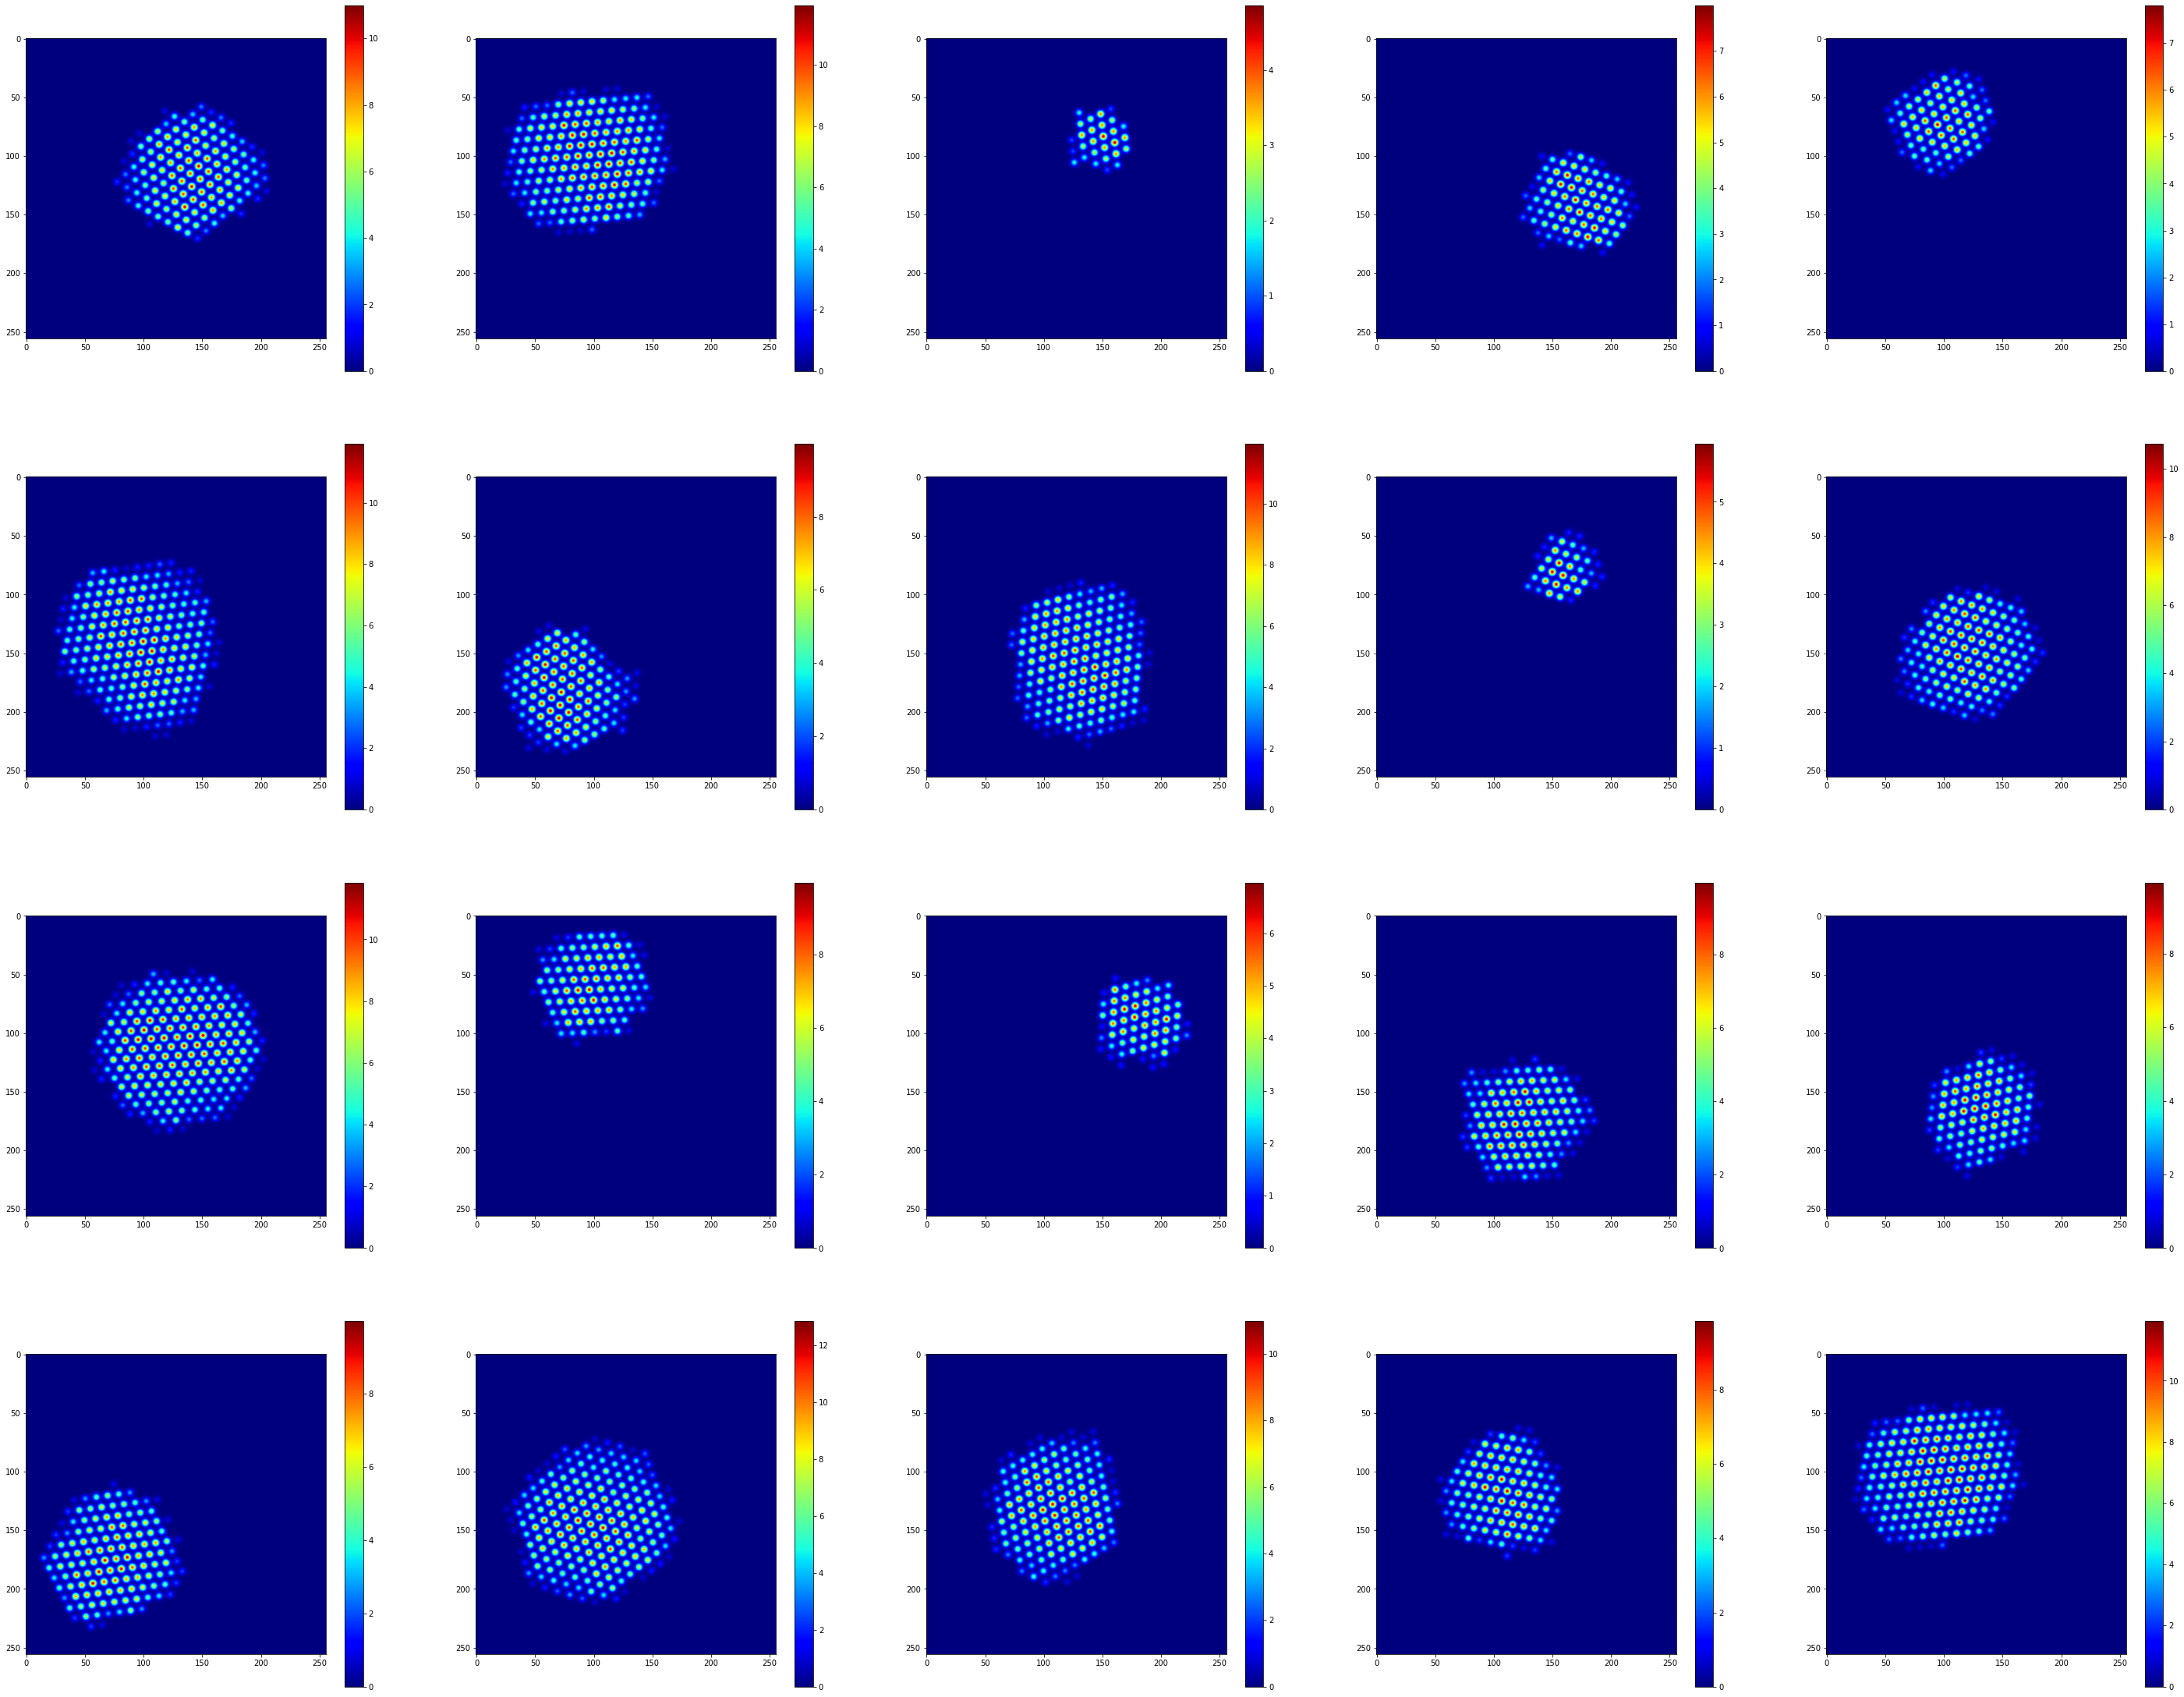

In [4]:
fig=plt.figure(figsize=(50,50))
for i in range(20):
    label=np.load(test_labels_path.format(i))
    fig.add_subplot(5,5,i+1)

    plt.imshow(label[0,:,:,0],'jet',interpolation='gaussian')
    plt.colorbar()

Visualizing the corresponding preidictions obtained with our trained set of weights. The weights corresponds to epoch 18 of the regression model 

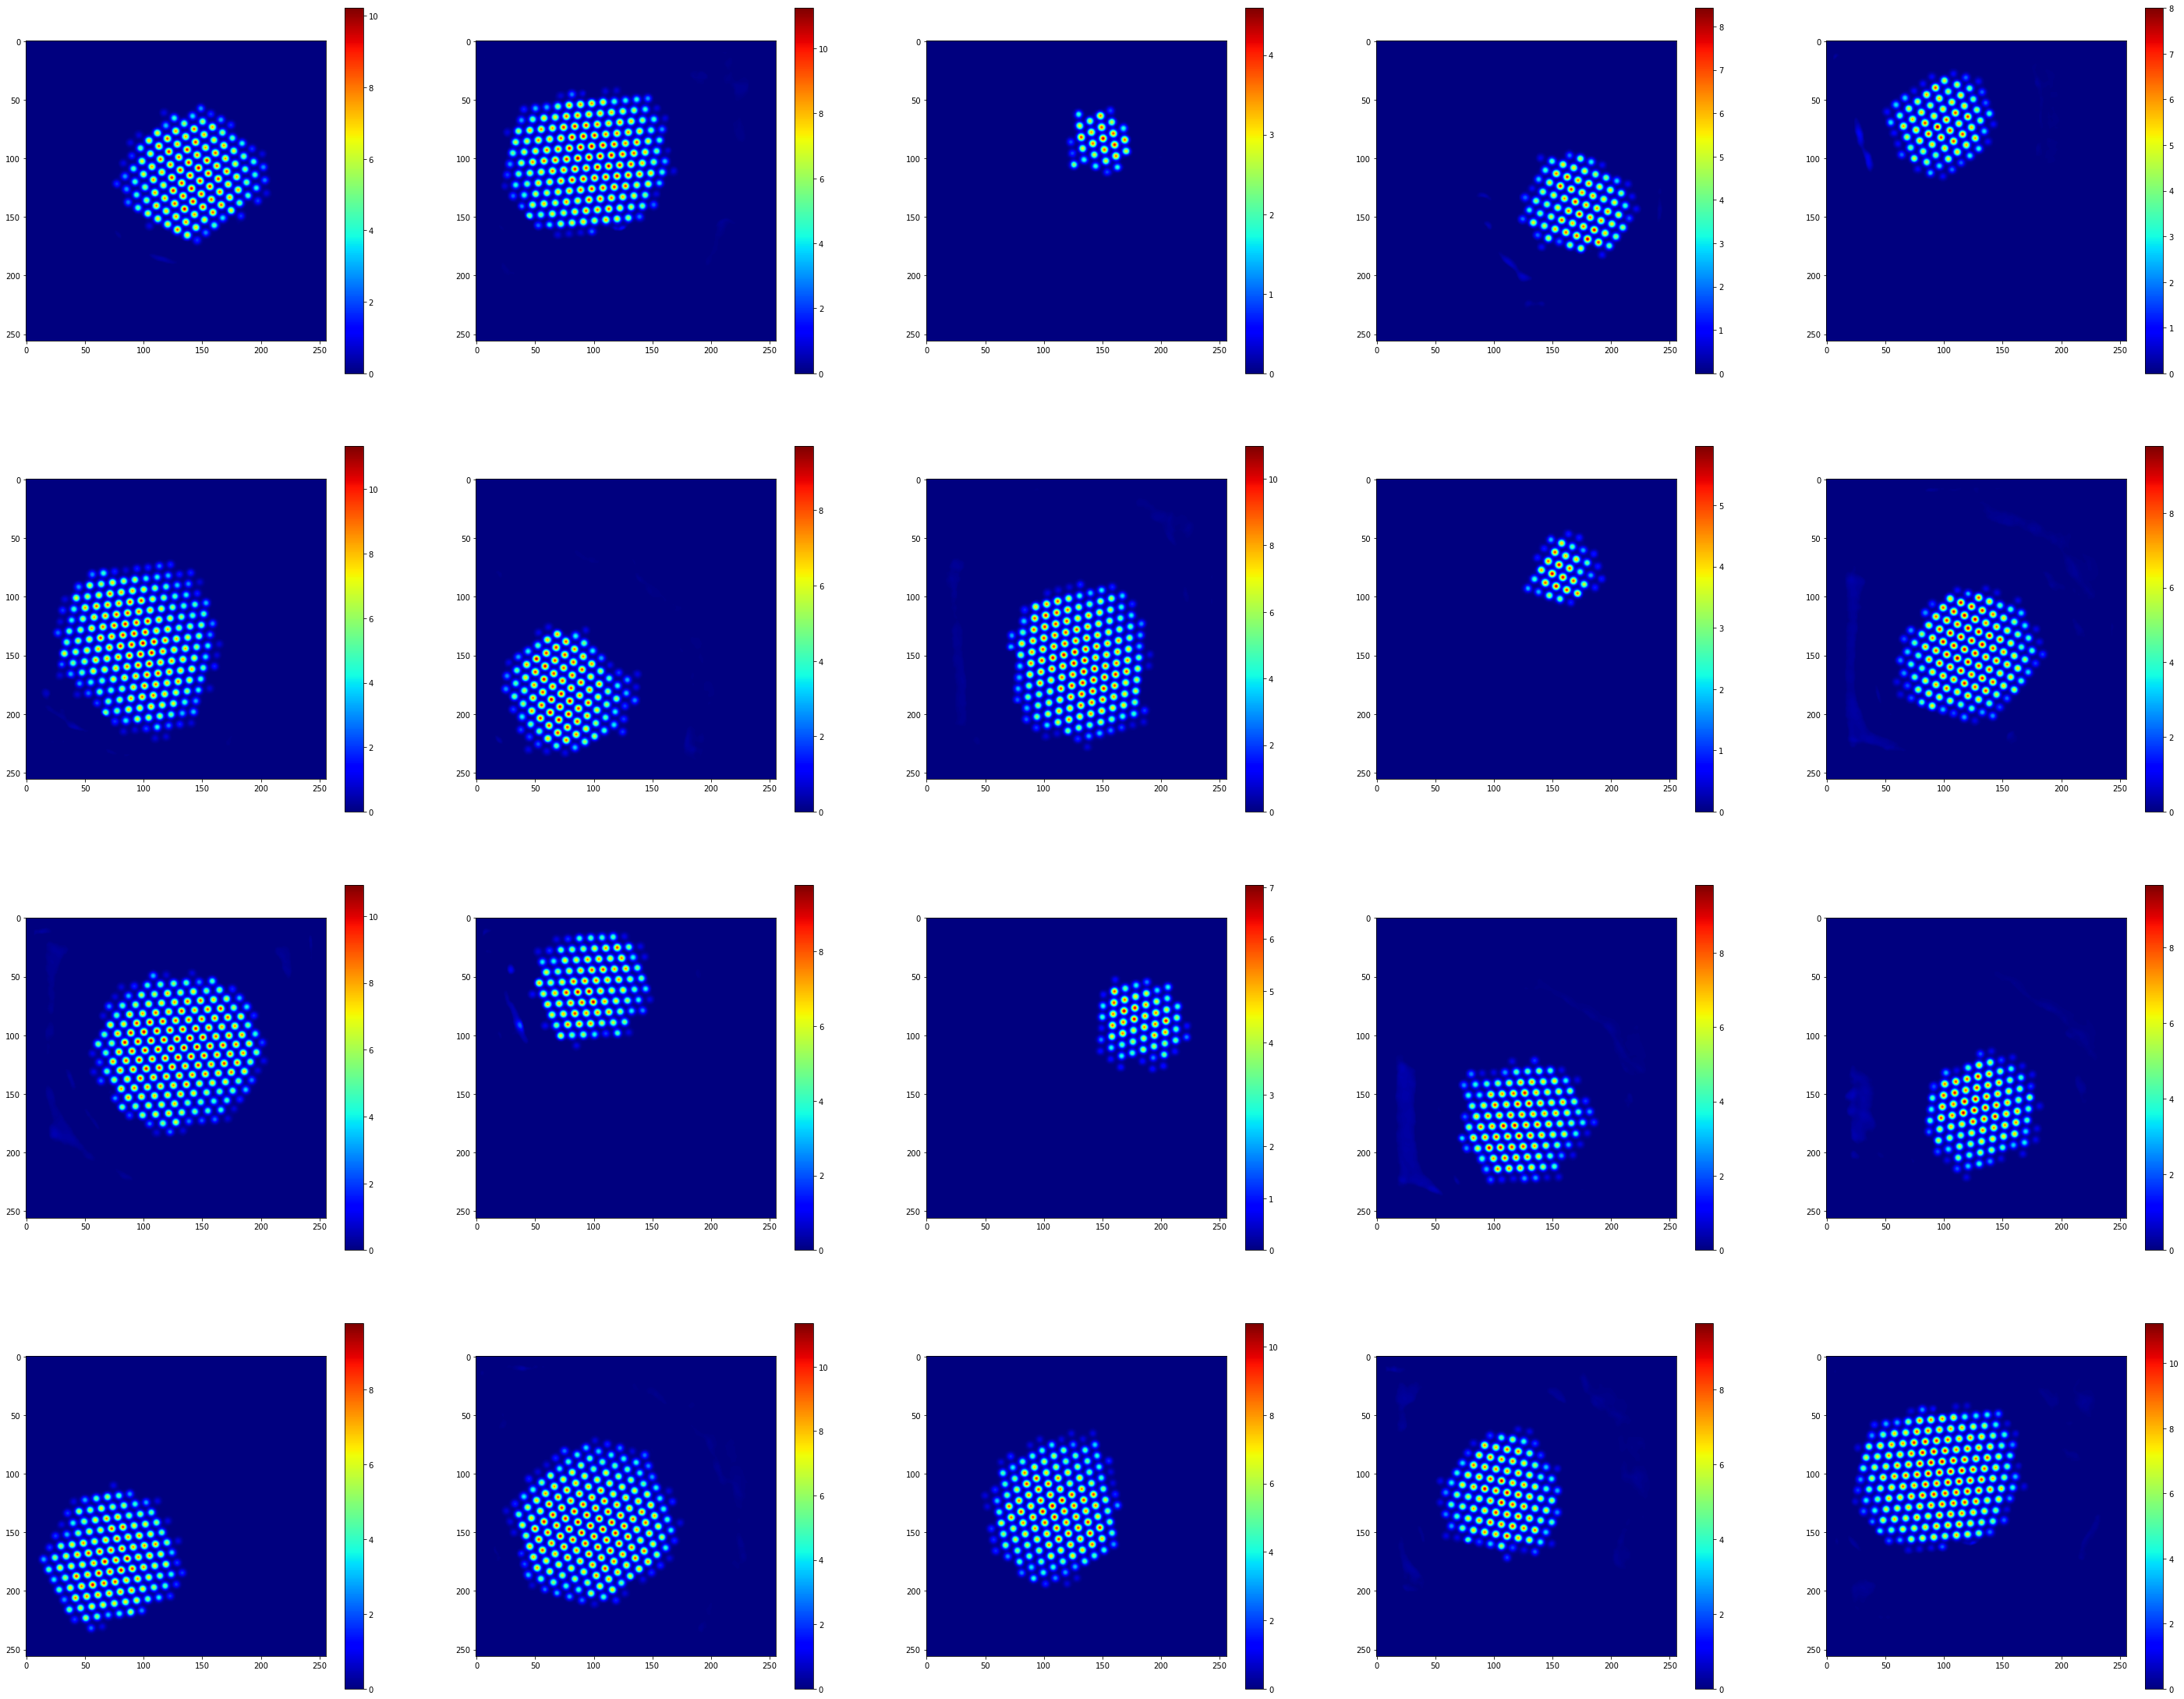

In [5]:
fig=plt.figure(figsize=(50,50))
for i in range(20):
    prediction=np.load(test_predictions_path.format(i))
    fig.add_subplot(5,5,i+1)

    plt.imshow(prediction[0,:,:,0],'jet',interpolation='gaussian')
    plt.colorbar()

In [6]:
predictions=[]
r2_heights=[]
for i in range(20):
    image=np.load(test_images_path.format(i))
    label=np.load(test_labels_path.format(i))
    
    # load our own predictions
    prediction=np.load(test_predictions_path.format(i))
    
    performance_CH_object=performance_CH(prediction,label)
    
    predictions.append(prediction)
    r2_heights.append(performance_CH_object.get_r2_heights())

Visualizing the R2 scores for each image:

In [7]:
for i in range(len(r2_heights)):
    print('R2 on image '+str(i+1)+': '+str(r2_heights[i]))

R2 on image 1: 0.9679619518218123
R2 on image 2: 0.9567872606484829
R2 on image 3: 0.942798774975992
R2 on image 4: 0.9138252639197074
R2 on image 5: 0.9783950613100735
R2 on image 6: 0.9662667451069209
R2 on image 7: 0.9639080241438249
R2 on image 8: 0.9525466093584024
R2 on image 9: 0.9472011736184267
R2 on image 10: 0.9476305933126166
R2 on image 11: 0.9370842986768775
R2 on image 12: 0.9322520007298869
R2 on image 13: 0.9241692089692192
R2 on image 14: 0.9091943204984435
R2 on image 15: 0.9455630796422185
R2 on image 16: 0.9492797773947863
R2 on image 17: 0.9666446690030724
R2 on image 18: 0.9781379905262418
R2 on image 19: 0.9621309696697846
R2 on image 20: 0.954246106047952


With the following lines the user is able to test the model and visualize the results obtained by training the neural network on its own training data. 
The main steps are the definition, the compilation of the model and the loading of the trained weights

Loading the model:

- input_channel=1: the HRTEM images are simulated with a single defocus value.
- input_shape=(256,256): image size.
- output channel=1: only a single output class is present in the regression scheme. In a standard semantic segmenatation procedure, the output channel is >1, corresponding to the number of classes to predict. In the classification model we have described in the manuscript and it is not present here, we have considered a total of 16 classes corresponding to column heights ranging from 1 to 16.

The model can be in serial or parallel mode depending on the gpus available on the user's machine.

In [9]:
input_channel=1
input_shape=(256,256)
input_tensor = keras.Input(shape=input_shape+(input_channel,))
output_channel=1
serial_model=CNN(input_tensor,output_channels=output_channel)
    
numgpus = 1

if numgpus >1:
     model=multi_gpu_model(serial_model,gpus=numgpus)
else:
    model=serial_model

Compiling the model with the 'adam' optimizer and the mean squared error 'mse'. The 'mse' metric is necessary to use the model in the regression scheme.

In [10]:
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

Load the weights computed during the training from folder. 

- trained_weights: weights computed by training the model from scratch on the images generated with make_training_data.py. Once the model has been trained, it must be tested on the images generated with 'make_test_data.py' and contained in the folder 'data/test/images/.

In [ ]:

epoch=... # epoch for which the model is tested
weights_folder_path='weights/trained_weights/epoch-{}.h5'
model.load_weights(weights_folder_path.format(epoch))

Test takes action:

- in every step of the for loop a single image is loaded from folder, together with the corresponding label.
- the prediction is computed with the commande 'model.predict(image)'.
- the class 'performance_CH' is used to evaluate the performance of the model. By giving in input the prediction and the label, the object of the class 'performance_CH_object' is created. Then, the R2 score between the predicted heights and the true heights is calculates using the function 'get_r2_heights' of the class 'performance_CH' is used.

In [ ]:
predictions=[]
r2_heights=[]
for i in range(20):
    image=np.load(test_images_path.format(i))
    label=np.load(test_labels_path.format(i))
    
    # making predictions
    prediction=model.predict(image)
    performance_CH_object=performance_CH(prediction,label)
    
    predictions.append(prediction)
    r2_heights.append(performance_CH_object.get_r2_heights())
    

Visualizing the predictions:

In [ ]:
fig=plt.figure(figsize=(30,30))
for i in range(20):
    fig.add_subplot(5,5,i+1)
    prediction=predictions[i]
    plt.imshow(prediction[0,:,:,0],'jet')
    plt.colorbar()

Visualizing the R2 scores for each image:

In [ ]:
for i in range(len(r2_heights)):
    print('R2 on image '+str(i+1)+': '+str(r2_heights[i]))